A very simple __Recurrent Neural Network__ tutorial.
In particular, a *very simple* __LSTM__ implementation tutorial using __TensorFlow__ library.
We demonstrate sequence recognition problem with 1-dimensional data (square-wave vs sine-wave)

The goals of this tutorial are:
* To keep code as simple as possible, so that its useful for beginners in Tensorflow/RNN
* To focus on the basic ideas, and not necessarily the best practices in coding
* No dependency on any external data source, this tutorial generates the data for you
* To help developers apply some of the ideas presented here, to their own real-world applications

Author: Chandan Gope

Apologies in advance for not providing detailed comments. But I hope the code is self-explanatory, given that I have tried to keep it very simple.
Feel free to test it with various parameter configurations and see what it does. But I myself have not tested it beyond what I present. If the code breaks, feel free to fix it and learn in the process!

In [301]:
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

In [302]:
sequence_length = 16    #how many time-steps in my RNN
input_dimension = 1     #our data is just 1-dimensional
num_classes = 2         #our classes are - 'square-wave' and 'sine-wave'
noise_stdev = 0.4       # stdev of noise we want to add to the waveforms

In [303]:
#Lets generate square and sine waveforms, with noise added
def generateWaveforms(noise_stdev=0.0):
    num_points = np.random.randint(36, 48) #at least 36, and less than 48
    noise = np.random.normal(0, noise_stdev, num_points)
    t = np.linspace(0, 1, num_points, endpoint=False)
    sq = signal.square(2 * np.pi * 5 * t) + noise
    si = np.sin(2 * np.pi * 5 * t) + noise

    #select a subset of consecutive points, with a random starting point
    subset_points = sequence_length #should be less than 36
    start_index = np.random.randint(0, 36-subset_points)
    sq_subset = sq[start_index:start_index+subset_points]
    t_sq_subset = t[start_index:start_index+subset_points]

    start_index = np.random.randint(0, 36-subset_points)
    si_subset = si[start_index:start_index+subset_points]
    t_si_subset = t[start_index:start_index+subset_points]
    
    return (sq_subset, si_subset)

In [304]:
def generateBatch(noise_stdev, batch_size=2):
    #we have 2 classes (square=1, sine=0), and half of the batch will be square-waves and other half will be sine-waves
    batch_size_per_class = batch_size/2
    X = np.empty((0, sequence_length, input_dimension))
    Y = np.empty((0, 2))
    for r in range(int(batch_size_per_class)):
        sq, si = generateWaveforms(noise_stdev)
        X = np.append(X, [sq[:,np.newaxis]], axis=0)
        Y = np.append(Y, [np.array([1,0])], axis=0)
        
        X = np.append(X, [si[:,np.newaxis]], axis=0)
        Y = np.append(Y, [np.array([0,1])], axis=0)
    
    return X, Y

Type of X: <class 'numpy.ndarray'>
Shape of X (batch_size, sequence_length, input_dimension) = (12, 16, 1)
Type of y: <class 'numpy.ndarray'>
Shape of y (batch_size, num_classes) = (12, 2)


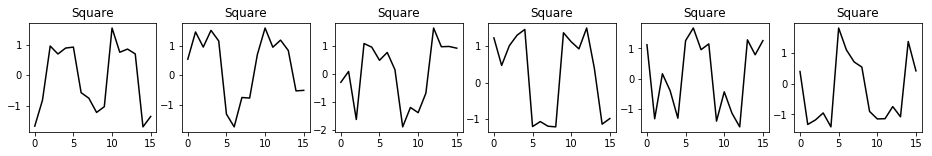

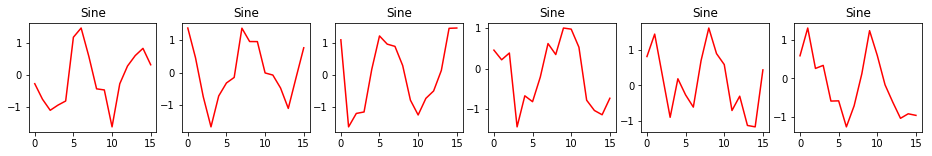

In [305]:
batch_size = 12 #keep it as a multiple of 2

X, y = generateBatch(noise_stdev, batch_size)

#Print the type and shapes of the arrays, so we are not lost!
print("Type of X: {0}".format(type(X)))
print("Shape of X (batch_size, sequence_length, input_dimension) = {0}".format(X.shape))
print("Type of y: {0}".format(type(y)))
print("Shape of y (batch_size, num_classes) = {0}".format(y.shape))

#Now lets plot them, to see what they look like
fig_square=plt.figure(figsize=(16,2))
fig_sine=plt.figure(figsize=(16,2))
index_square = 0
index_sine = 0
for r in range(batch_size):
    is_square = y[r,0]==1
    data = X[r,].flatten()
    if(is_square):
        index_square += 1
        ax=fig_square.add_subplot(1,int(batch_size/2),index_square)
        ax.plot(data, 'k')
        ax.set_title('Square')
    else:
        index_sine += 1
        ax=fig_sine.add_subplot(1,int(batch_size/2),index_sine)
        ax.plot(data, 'r')
        ax.set_title('Sine')
    

I noticed that with noise_stdev = 0.3, it starts becoming hard to visually tell apart the square-wave from sine-wave. In your experiments, try with 
* noise_stdev < 0.3 => the RNN should be able to do a good job in learning
* noise_stdev > 0.3 => the RNN should NOT be able to do a good job in learning

### Now Tensorflow stuff

In [306]:
def runRNN(X, weights, biases):
    # Our X has shape: (batch_size, sequence_length, input_dimension)
    # TF wants: a list of 'sequence_length' tensors, each of shape (batch_size, input_dimension)
    # We will use unstack to get a list of 'sequence_length' tensors, each of shape (batch_size, input_dimension)
    X = tf.unstack(X, sequence_length, 1)

    # Create a lstm cell with tensorflow
    cell = tf.contrib.rnn.BasicLSTMCell(hidden_nodes)

    # Get outputs (dont care about states)
    outputs, states = tf.contrib.rnn.static_rnn(cell, X, dtype=tf.float32)

    # We just care about the last output in the list
    return tf.matmul(outputs[-1], W['out']) + b['out']

In [311]:
# Construct the computational graph.
tf.reset_default_graph()
X = tf.placeholder("float", [None, sequence_length, input_dimension]) #Batch-size x 16 x 1
Y = tf.placeholder("float", [None, num_classes]) # Batch-size x 2

hidden_nodes = 64 # number of nodes 

W = {
    'out': tf.Variable(tf.random_normal([hidden_nodes, num_classes]))
}
b = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

batch_size = 64 #keep it as a multiple of 2
learning_rate = 0.001
training_steps = 10000
display_step = 1000
noise_stdev = 0.20       # stdev of noise we want to add to the waveforms

#ops for training
logits = runRNN(X, W, b)
prediction = tf.nn.softmax(logits)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

#ops for computing accuracy
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# init op
init = tf.global_variables_initializer()

with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = generateBatch(noise_stdev, batch_size)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate loss and accuracy for the batch
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
            print("Step " + str(step) + ", Loss= " + "{:.3f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("{0} training steps completed".format(training_steps))
    
    #Now check accuracy on some test data, with a higher noise than that in training
    noise_stdev = 0.30
    batch_size = 1000
    test_x, test_y = generateBatch(noise_stdev, batch_size)
    test_acc = sess.run(accuracy, feed_dict={X: test_x, Y: test_y})
    print("\nTesting Accuracy on {0} samples: {1}".format(batch_size, test_acc) )
    
    

Step 1, Loss= 0.986, Training Accuracy= 0.500
Step 1000, Loss= 0.680, Training Accuracy= 0.703
Step 2000, Loss= 0.680, Training Accuracy= 0.625
Step 3000, Loss= 0.654, Training Accuracy= 0.812
Step 4000, Loss= 0.621, Training Accuracy= 0.859
Step 5000, Loss= 0.561, Training Accuracy= 0.875
Step 6000, Loss= 0.286, Training Accuracy= 0.984
Step 7000, Loss= 0.058, Training Accuracy= 1.000
Step 8000, Loss= 0.060, Training Accuracy= 0.969
Step 9000, Loss= 0.026, Training Accuracy= 1.000
Step 10000, Loss= 0.009, Training Accuracy= 1.000
10000 training steps completed

Testing Accuracy on 1000 samples: 0.9610000252723694
